#### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles

from tqdm import tqdm

In [2]:
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

#### Create datasets

In [4]:
nTot = 1000
circles_data, circles_labels = make_circles(n_samples = nTot)

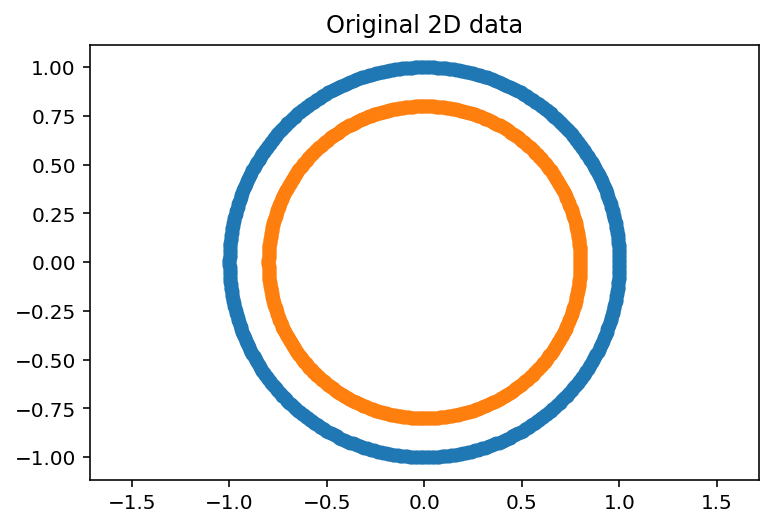

In [5]:
idx_0 = np.where(circles_labels==0)
idx_1 = np.where(circles_labels==1)
plt.scatter(circles_data[idx_0,0],circles_data[idx_0,1])
plt.scatter(circles_data[idx_1,0],circles_data[idx_1,1])
plt.axis('equal')
plt.title('Original 2D data')
plt.show()

#### Split into train and test datasets

In [6]:
fracTrain = 0.8
fracTest = 1 - fracTrain

nTrain = int(nTot*fracTrain)
nTest = nTot - nTrain

In [7]:
repsTrain_solo = circles_data[:nTrain]
repsTest_solo = circles_data[nTrain:]

labelsTrain = circles_labels[:nTrain].astype(float)
labelsTest = circles_labels[nTrain:].astype(float)

In [8]:
dimProj = 10
A = np.random.rand(2,dimProj)

repsTrain_proj = repsTrain_solo@A
repsTest_proj = repsTest_solo@A

#### Convert data into tensors

In [9]:
dataTrain = Variable(torch.from_numpy(repsTrain_proj)).requires_grad_(True)
yTrain = Variable(torch.from_numpy(labelsTrain)).requires_grad_(True)

dataTest = Variable(torch.from_numpy(repsTest_proj)).requires_grad_(True)
yTest = Variable(torch.from_numpy(labelsTest)).requires_grad_(True)

#### Train and test loaders

In [10]:
## create dataset and dataloader
tensorTrainData = TensorDataset(dataTrain,yTrain)
tensorTestData = TensorDataset(dataTest,yTest)

bs = 1 ## batch size
train_loader = DataLoader(tensorTrainData, batch_size=bs, shuffle=True)
train_loader_noShuffle = DataLoader(tensorTrainData, batch_size=bs, shuffle=False)
test_loader = DataLoader(tensorTestData, batch_size=bs, shuffle=False)

#### Test for CUDA

In [11]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('No GPU, training on CPU')
    device = torch.device('cpu')
else:
    print('GPU found, training on GPU')
    device = torch.device('cuda')

GPU found, training on GPU


#### Pseudo-RNN AE

In [12]:
n_latent = 2
n_rounds = 3
kcap = int(dimProj*0.8)

In [13]:
class RNNAE(nn.Module):
    def __init__(self, hidden_dim = n_latent, n_feats=dimProj, T=n_rounds, kcap=kcap):
        super(RNNAE, self).__init__()
        
        self.kcap = kcap
        self.T = T
        
        ##Input layer
        self.input_layer = nn.Linear(n_feats,n_latent,bias=False)
        
        ###RNN layer
        self.RNN_layer = nn.Linear(n_latent,n_latent,bias=False)
        
        ##Output layer
        self.output_layer = nn.Linear(n_latent,n_feats,bias=False)
        
        self.activation = nn.ReLU()
        
        
    def forward(self, x):
        
        def firing_rate(x, kc=self.kcap):
            nSamp, nNodes = x.shape
            firing_rate_mat = torch.zeros(nSamp,nNodes)
            keep_idxs = torch.argsort(x,dim=1)[:,:kc]
            for kk in range(nSamp):
                firing_rate_mat[kk,keep_idxs[kk]] = 1
            return firing_rate_mat
        
        frIn = firing_rate(x)
        
        x = self.input_layer(x)
        x = self.activation(x)
        
        nSamp, nNodes = x.shape
        frRNN = torch.zeros(nSamp,self.T,nNodes)
        
        for t in range(self.T):
            x = self.RNN_layer(x)
            x = self.activation(x)
            frRNN[:,t,:] = firing_rate(x)
            
        x_latent = x ## latent representation after the last RNN layer
        
        x_recon = self.output_layer(x)
        frOut = firing_rate(x_recon)
        
        return x_recon, x_latent, frIn, frRNN, frOut

#create the NN
model = RNNAE()
model.to(device)
print(model)

RNNAE(
  (input_layer): Linear(in_features=10, out_features=2, bias=False)
  (RNN_layer): Linear(in_features=2, out_features=2, bias=False)
  (output_layer): Linear(in_features=2, out_features=10, bias=False)
  (activation): ReLU()
)


In [14]:
model

RNNAE(
  (input_layer): Linear(in_features=10, out_features=2, bias=False)
  (RNN_layer): Linear(in_features=2, out_features=2, bias=False)
  (output_layer): Linear(in_features=2, out_features=10, bias=False)
  (activation): ReLU()
)

#### Count parameters

In [15]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

44

#### Trial pass

In [16]:
for data, target in train_loader:
    if train_on_gpu:
        data, target = data.float().cuda(), target.float().cuda()
        reconTP, latentTP, frInTP, frRNNTP, frOutTP = model(data)

In [17]:
# print(reconTP.shape)
# print(latentTP.shape)
# print(frInTP.shape)
# print(frRNNTP.shape)
# print(frOutTP.shape)

#### Updater networks

In [18]:
class Updater(nn.Module):
    def __init__(self, dimIn_in=n_rounds+1, dimIn_RNN=n_rounds*2, dimIn_out=n_rounds+1,
                 dim_inter=n_rounds, n_out=1,
                 n_feats = dimProj, n_latent = n_latent,
                 bigModel=model, GPU=train_on_gpu):
        
        super(Updater, self).__init__()
        
        ##In
        self.in_layer1 = nn.Linear(dimIn_in,dim_inter)
        self.in_layer2 = nn.Linear(dim_inter,n_out)
        
        ##RNN
        self.rnn_layer1 = nn.Linear(dimIn_RNN,dim_inter)
        self.rnn_layer2 = nn.Linear(dim_inter,n_out)
        
        ##Out
        self.out_layer1 = nn.Linear(dimIn_out,dim_inter)
        self.out_layer2 = nn.Linear(dim_inter,n_out)
        
        self.n_feats = n_feats
        self.n_latent = n_latent
        
        self.bigModel = bigModel
        
        self.GPU=GPU
        
    def forward(self,x):
        
        self.bigModel.eval()
        recon, latents, frIn, frRNN, frOut = self.bigModel(x)
        
        def deltaW(di,dj,fri,frj,L1,L2,GPU=self.GPU,rnn=None,ipLin=None):
            
            if rnn:
                dw = torch.zeros(dj,di)
                for ii in range(di):
                    for jj in range(dj):
                        frBatch = torch.cat((fri[:,:,ii],frj[:,:,jj]),1)
                        if GPU:
                            frBatch, dw = frBatch.cuda(), dw.cuda()
                            inter1 = L1(frBatch)
                            inter2 = L2(inter1)
                        dw[jj,ii] = torch.mean(inter2,0)[0]                

            else:
                dw = torch.zeros(dj,di)
                for ii in range(di):
                    for jj in range(dj):
                        if ipLin:
                            frBatch = torch.cat((fri[:,ii].view(-1,1),frj[:,:,jj]),1)
                        else:
                            frBatch = torch.cat((fri[:,:,ii],frj[:,jj].view(-1,1)),1)
                        if GPU:
                            frBatch, dw = frBatch.cuda(), dw.cuda()
                            inter1 = L1(frBatch)
                            inter2 = L2(inter1)
                        dw[jj,ii] = torch.mean(inter2,0)[0]

            return nn.Parameter(dw)
        
            self.bigModel.input_layer.weight=nn.Parameter(bigModel.input_layer.weight+deltaW(self.n_feats,self.n_latent,
                                                                                            frIn,frRNN,
                                                                                            self.in_layer1,
                                                                                            self.in_layer2,
                                                                                            rnn=False,
                                                                                            ipLin=True))
        
            self.bigModel.RNN_layer.weight=nn.Parameter(bigModel.RNN_layer.weight+deltaW(self.n_latent,self.n_latent,
                                                                                        frRNN,frRNN,
                                                                                        self.rnn_layer1,
                                                                                        self.rnn_layer2,
                                                                                        rnn=True,
                                                                                        ipLin=False))
            
            self.bigModel.output_layer.weight=nn.Parameter(bigModel.output_layer.weight+deltaW(self.n_latent,self.n_feats,
                                                                                              frRNN,frOut,
                                                                                               self.out_layer1,
                                                                                               self.out_layer2,
                                                                                               rnn=False,
                                                                                               ipLin=False))
            
            self.bigModel.eval()
            recon, latents, frIn, frRNN, frOut = self.bigModel(x)
            
        return recon, latents

In [19]:
bigUpdater = Updater()
bigUpdater.to(device)

Updater(
  (in_layer1): Linear(in_features=4, out_features=3, bias=True)
  (in_layer2): Linear(in_features=3, out_features=1, bias=True)
  (rnn_layer1): Linear(in_features=6, out_features=3, bias=True)
  (rnn_layer2): Linear(in_features=3, out_features=1, bias=True)
  (out_layer1): Linear(in_features=4, out_features=3, bias=True)
  (out_layer2): Linear(in_features=3, out_features=1, bias=True)
  (bigModel): RNNAE(
    (input_layer): Linear(in_features=10, out_features=2, bias=False)
    (RNN_layer): Linear(in_features=2, out_features=2, bias=False)
    (output_layer): Linear(in_features=2, out_features=10, bias=False)
    (activation): ReLU()
  )
)

In [20]:
count_parameters(bigUpdater)

107

#### Hebbian learning

#### Specify loss function and optimizers

In [21]:
#specify loss function
criterion = nn.MSELoss()

#optimizers
eta = 0.001

optimizer = torch.optim.Adam(bigUpdater.parameters(),lr=eta)

#### Addresses to collect activations and models

In [22]:
pp = 'C:/Users/abalwani6/Desktop/Spring 2021/Classes/CS 8803 CAB/Final-Project/'
npp = 'saved-models-hebbian-RNNAE/'
pp_npy = pp+npp+'npys/'
pp_pts = pp+npp+'pts/'

#### Train updater models, i.e., outer loop

In [23]:
#number of epochs
n_epochs = 20
div = n_epochs//20 ## try ensuring that number used to divide by is a factor of n_epochs
train_losses = np.zeros(n_epochs)

train_loss_min = np.Inf
best_epoch = 0

for epoch in tqdm(range(1,n_epochs+1)):
    train_loss = 0.0
    cnt = 0
    
    #train updater model
    bigUpdater.train()
    
    for data, target in train_loader:
        if train_on_gpu:
            data, target = data.float().cuda(), target.float().cuda()
        
        optimizer.zero_grad()

        recon_train, latents_train = bigUpdater(data)
        
        
        
        loss = criterion(recon_train,data) #calculate the loss for the batch on meta-objective
        loss.backward() #backprop
        
        optimizer.step()
        train_loss += loss.item()*data.size(0) #update training loss
        
        
    #calculate average loss
    train_loss = train_loss/len(train_loader.dataset)
    
    #training/validation stats
    train_losses[epoch-1] = train_loss
    
    #save model if the training loss decreased
    if train_loss <= train_loss_min:
        print('Epoch: {}, Train Loss Decreased!! ({:.6f}-->{:.6f})'.format(epoch,train_loss_min,train_loss))
        torch.save(model.state_dict(),pp_pts+'hebbian-RNNAE.pt')
        torch.save(bigUpdater.state_dict(),pp_pts+'bigUpdater.pt')
        train_loss_min = train_loss
        best_epoch = epoch
        
    if epoch%div == 0:
        torch.save(model.state_dict(), pp_pts+'hebbian-RNNAE_epoch_'+str(epoch)+'.pt')
        torch.save(bigUpdater.state_dict(),pp_pts+'bigUpdater_epoch'+str(epoch)+'.pt')
        
        activations_hidden_np = np.zeros((nTest,n_latent))
        
        activations_out_np = np.zeros((nTest,dimProj))
        
        # track test loss
        test_loss = 0.0
        
        bigUpdater.eval()
        for data_test, target_test in test_loader:
            if train_on_gpu:
                data_test, target_test = data_test.float().cuda(), target_test.float().cuda()
            
            ## outputs
            output_test, latents_test = bigUpdater(data_test)
            
            # calculate the batch loss
            loss = criterion(output_test,data_test)
            
            # update test loss 
            test_loss += loss.item()*data_test.size(0)
            
            latents_test = np.squeeze(latents_test.detach().cpu().numpy())
            output_test = np.squeeze(output_test.detach().cpu().numpy())
            
            for i in range(bs):
                if bs>1:
                    if i < len(data_test):
                        label = target_test.data[i]
                        activations_hidden_np[cnt] = latents_test[i]
                        activations_out_np[cnt] = output_test[i,-1]
                        cnt += 1
                elif bs==1:
                    label = target_test.data[i]
                    activations_hidden_np[cnt] = latents_test
                    activations_out_np[cnt] = output_test
                    cnt += 1

        np.save(pp_npy+'hebbian-RNNAE_latent_epoch_'+str(epoch), activations_hidden_np)
        
        np.save(pp_npy+'hebbian-RNNAE_out_epoch_'+str(epoch), activations_out_np)
        
        # average test loss
        test_loss = test_loss/len(test_loader.dataset)
        print('Test Loss: {:.6f}\n'.format(test_loss))

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1, Train Loss Decreased!! (inf-->0.181812)


  5%|▌         | 1/20 [00:03<00:57,  3.04s/it]

Test Loss: 0.137803

Epoch: 2, Train Loss Decreased!! (0.181812-->0.131569)


 10%|█         | 2/20 [00:06<00:54,  3.02s/it]

Test Loss: 0.134074

Epoch: 3, Train Loss Decreased!! (0.131569-->0.129664)


 15%|█▌        | 3/20 [00:09<00:51,  3.02s/it]

Test Loss: 0.132569

Epoch: 4, Train Loss Decreased!! (0.129664-->0.128261)


 20%|██        | 4/20 [00:11<00:47,  2.99s/it]

Test Loss: 0.131595

Epoch: 5, Train Loss Decreased!! (0.128261-->0.127447)


 25%|██▌       | 5/20 [00:14<00:44,  2.97s/it]

Test Loss: 0.131111

Epoch: 6, Train Loss Decreased!! (0.127447-->0.127035)


 30%|███       | 6/20 [00:17<00:41,  2.96s/it]

Test Loss: 0.130875

Epoch: 7, Train Loss Decreased!! (0.127035-->0.126866)


 35%|███▌      | 7/20 [00:20<00:38,  2.96s/it]

Test Loss: 0.130869

Epoch: 8, Train Loss Decreased!! (0.126866-->0.126841)


 40%|████      | 8/20 [00:23<00:35,  2.95s/it]

Test Loss: 0.130841

Epoch: 9, Train Loss Decreased!! (0.126841-->0.126804)


 45%|████▌     | 9/20 [00:26<00:33,  3.04s/it]

Test Loss: 0.130845

Epoch: 10, Train Loss Decreased!! (0.126804-->0.126776)


 50%|█████     | 10/20 [00:30<00:31,  3.20s/it]

Test Loss: 0.130809

Epoch: 11, Train Loss Decreased!! (0.126776-->0.126754)


 55%|█████▌    | 11/20 [00:33<00:28,  3.20s/it]

Test Loss: 0.130755

Epoch: 12, Train Loss Decreased!! (0.126754-->0.126689)


 60%|██████    | 12/20 [00:36<00:25,  3.15s/it]

Test Loss: 0.130670

Epoch: 13, Train Loss Decreased!! (0.126689-->0.126634)


 65%|██████▌   | 13/20 [00:40<00:22,  3.17s/it]

Test Loss: 0.130539

Epoch: 14, Train Loss Decreased!! (0.126634-->0.126465)


 70%|███████   | 14/20 [00:43<00:18,  3.15s/it]

Test Loss: 0.129821

Epoch: 15, Train Loss Decreased!! (0.126465-->0.088247)


 75%|███████▌  | 15/20 [00:46<00:15,  3.11s/it]

Test Loss: 0.025885

Epoch: 16, Train Loss Decreased!! (0.088247-->0.015282)


 80%|████████  | 16/20 [00:49<00:12,  3.09s/it]

Test Loss: 0.012089

Epoch: 17, Train Loss Decreased!! (0.015282-->0.011684)


 85%|████████▌ | 17/20 [00:52<00:09,  3.09s/it]

Test Loss: 0.011736

Epoch: 18, Train Loss Decreased!! (0.011684-->0.011563)


 90%|█████████ | 18/20 [00:55<00:06,  3.06s/it]

Test Loss: 0.011696

Epoch: 19, Train Loss Decreased!! (0.011563-->0.011524)


 95%|█████████▌| 19/20 [00:58<00:03,  3.01s/it]

Test Loss: 0.011776



100%|██████████| 20/20 [01:01<00:00,  3.06s/it]

Test Loss: 0.011846



Text(0, 0.5, 'MSE')

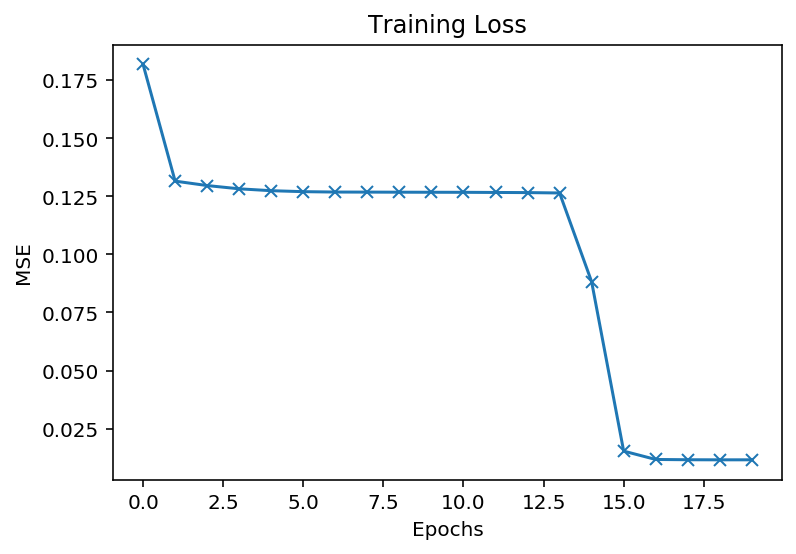

In [24]:
plt.plot((train_losses),'-x')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')

In [25]:
# np.save('losses_good_run_0_50',train_losses)

#### Load best model

In [26]:
## best epoch = 50
print(best_epoch)

19


In [55]:
model.load_state_dict(torch.load(pp_pts+'hebbian-RNNAE_epoch_12.pt'))

<All keys matched successfully>

In [56]:
model.eval()

test_loss = 0.0
        
activations_latent_np = np.zeros((nTest,n_latent))
activations_out_np = np.zeros((nTest,dimProj))

cnt = 0

for data_test, target_test in test_loader:
    if train_on_gpu:
        data_test, target_test = data_test.float().cuda(), target_test.float().cuda()
    data_test, target_test = data_test.float(), target_test.float()
    ## outputs
    output_test, act_hidden = bigUpdater(data_test)

    # calculate the batch loss
    loss = criterion(output_test, data_test)

    # update test loss 
    test_loss += loss.item()*data_test.size(0)

    act_hidden = np.squeeze(act_hidden.detach().cpu().numpy())
    output_test = np.squeeze(output_test.detach().cpu().numpy())

    for i in range(bs):
        if i < len(data_test):
            label = target_test.data[i]

            activations_hidden_np[cnt] = act_hidden

            activations_out_np[cnt] = output_test

            cnt += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

Test Loss: 0.130670



In [57]:
model.eval()

train_loss = 0.0
        
activations_latent_train_np = np.zeros((nTrain,n_latent))
activations_out_train_np = np.zeros((nTrain,dimProj))

cnt = 0

for data_train, target_train in train_loader_noShuffle:
    if train_on_gpu:
        data_train, target_train = data_train.float().cuda(), target_train.float().cuda()
    data_train, target_train = data_train.float(), target_train.float()

    ## outputs
    output_train, act_hidden = bigUpdater(data_train)

    # calculate the batch loss
    loss = criterion(output_train, data_train)

    # update train loss 
    train_loss += loss.item()*data_train.size(0)

    act_hidden = np.squeeze(act_hidden.detach().cpu().numpy())
    output_train = np.squeeze(output_train.detach().cpu().numpy())

    for i in range(bs):
        if i < len(data_train):
            label = target_train.data[i]

            activations_latent_train_np[cnt] = act_hidden

            activations_out_train_np[cnt] = output_train

            cnt += 1

# average train loss
train_loss = train_loss/len(train_loader.dataset)
print('Test Loss: {:.6f}\n'.format(train_loss))

Test Loss: 0.126604



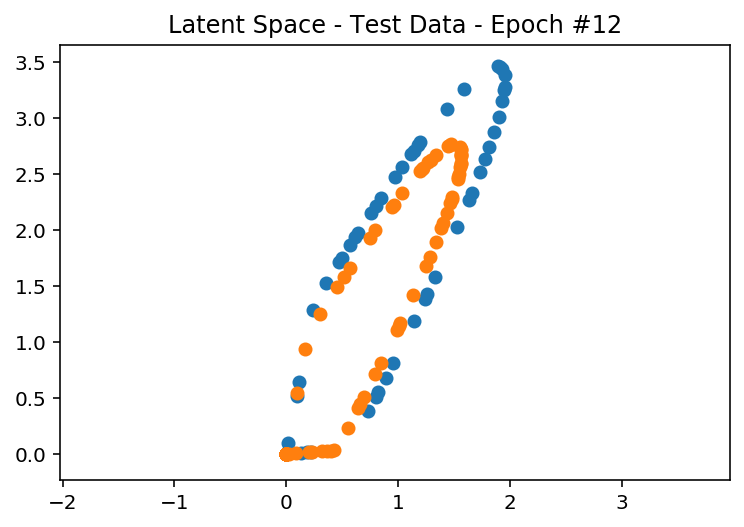

In [60]:
for ii in range(2):
    col = 'C' + str(ii)
    idx = np.where(labelsTest==ii)[0]
    plt.scatter(activations_hidden_np[idx,0],activations_hidden_np[idx,1],c=col)
plt.title('Latent Space - Test Data - Epoch #12')
plt.axis('equal')
plt.show()

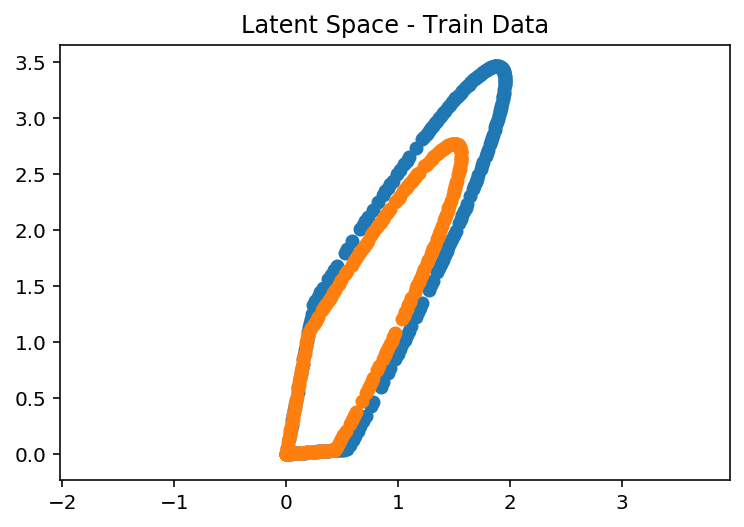

In [59]:
for ii in range(2):
    col = 'C' + str(ii)
    idx = np.where(labelsTrain==ii)[0]
    plt.scatter(activations_latent_train_np[idx,0],activations_latent_train_np[idx,1],c=col)
plt.title('Latent Space - Train Data')
plt.axis('equal')
plt.show()